In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
#from torchvision.datasets.utils import TensorDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
stats = ((0.4818, 0.4549, 0.4063), (0.2612, 0.2545, 0.2673))
tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [3]:
high_res = './less_images/high_res'
low_res = './less_images/low_res'

In [4]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, root1,root2, transform):
        super().__init__()
        self.root1 = root1
        self.root2 = root2
        self.transform = transform


    def __len__(self):
        return len(ImageFolder(self.root1))

    def __getitem__(self, idx): 
        x = ImageFolder(self.root1,self.transform)[idx][0]
        y = ImageFolder(self.root2,self.transform)[idx][0]

        return x, y

In [5]:
dataset=CustomDataset(low_res,high_res,tfms)

In [6]:
val_size = 500
train_size = len(dataset) - val_size
torch.manual_seed(43)
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4500, 500)

In [7]:
def denormalize(img_tensors):
    v=img_tensors
    v[0]=v[0] * stats[1][0] + stats[0][0]
    v[1]=v[1] * stats[1][1] + stats[0][1]
    v[2]=v[2] * stats[1][2] + stats[0][2]
    return v
def show_image(dl,dr):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax1.imshow(denormalize(dl).permute(1, 2, 0))
    ax2.set_xticks([]); ax2.set_yticks([])
    ax2.imshow(denormalize(dr).permute(1, 2, 0))
    
    f.set_figheight(18)
    f.set_figwidth(18)

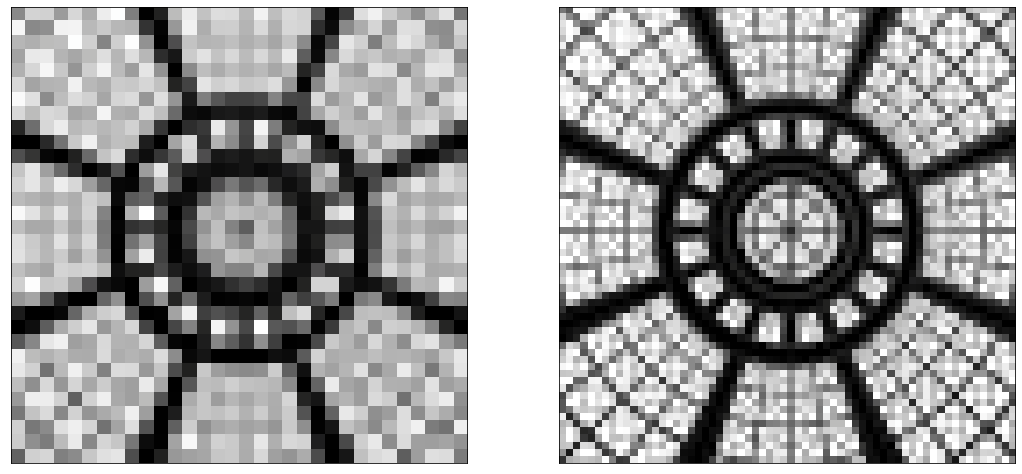

In [8]:
show_image(train_ds[465][0],train_ds[465][1])

In [17]:
# PyTorch data loaders
batch_size = 50
train_dl = DataLoader(train_ds, batch_size, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [11]:
class UpscalingBase(nn.Module):
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generate images
        loss = F.mse_loss(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate images
        loss = F.mse_loss(out, targets)   # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

In [12]:
class upscaler(UpscalingBase):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.classifier = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                            nn.Tanh())
        
    def forward(self, xb):
        out = self.classifier(xb)
        return out

In [13]:
model = to_device(upscaler(3,3), device)
model

upscaler(
  (classifier): Sequential(
    (0): ConvTranspose2d(3, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)

In [15]:
model.load_state_dict(torch.load('low_data_enhancer.pth'))

<All keys matched successfully>

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.1826156377792358}]

In [21]:
def predict_image(img1,img2, model):
    # Convert to a batch of 1
    xb = to_device(img1.unsqueeze(0),device)
    yb = model(xb)
    yb=torch.squeeze(yb)
    #print(yb.detach().cpu().shape)
    show_image(img1,yb.detach().cpu())

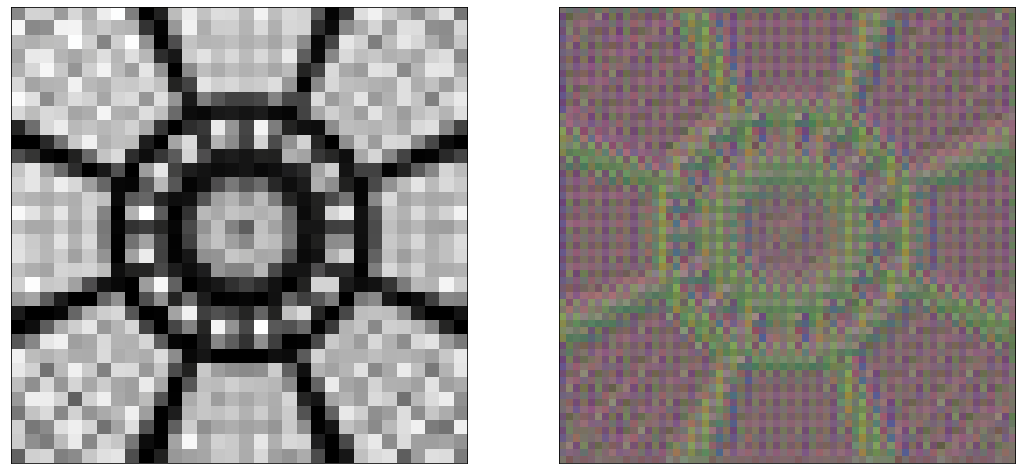

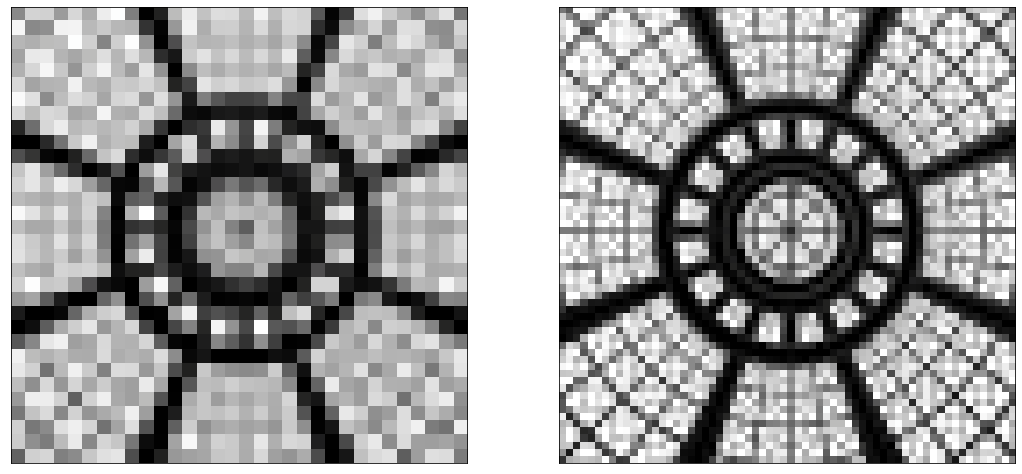

In [22]:
predict_image(train_ds[465][0],train_ds[465][1],model)
show_image(train_ds[465][0],train_ds[465][1])

In [23]:
lr = 0.01
epochs = 6

In [24]:
history = fit(epochs, lr,model,train_dl,val_dl,torch.optim.SGD)

Epoch [0], train_loss: 0.6226, val_loss: 0.4233
Epoch [1], train_loss: 0.3597, val_loss: 0.3427
Epoch [2], train_loss: 0.3114, val_loss: 0.3123
Epoch [3], train_loss: 0.2893, val_loss: 0.2953
Epoch [4], train_loss: 0.2758, val_loss: 0.2839
Epoch [5], train_loss: 0.2664, val_loss: 0.2753


In [27]:
history = fit(epochs, lr,model,train_dl,val_dl,torch.optim.SGD)

Epoch [0], train_loss: 0.2592, val_loss: 0.2686
Epoch [1], train_loss: 0.2534, val_loss: 0.2631
Epoch [2], train_loss: 0.2486, val_loss: 0.2585
Epoch [3], train_loss: 0.2446, val_loss: 0.2544
Epoch [4], train_loss: 0.2410, val_loss: 0.2509
Epoch [5], train_loss: 0.2379, val_loss: 0.2478


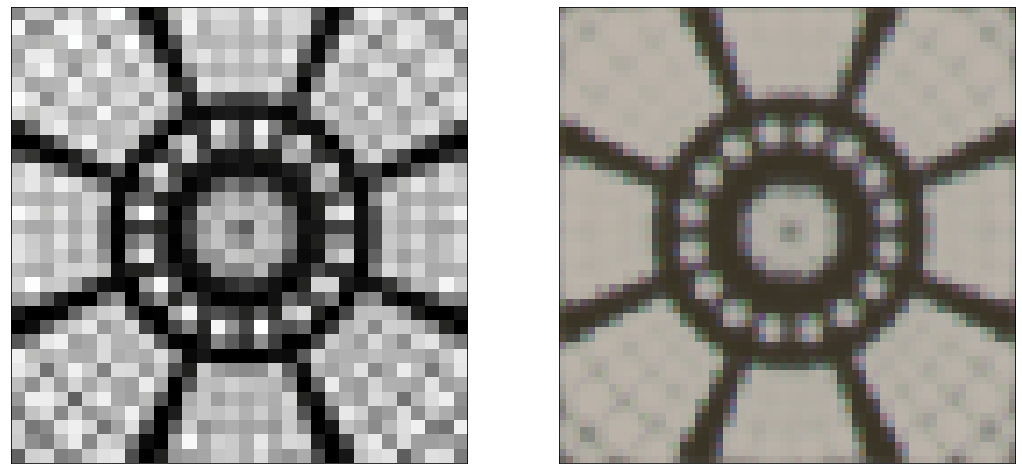

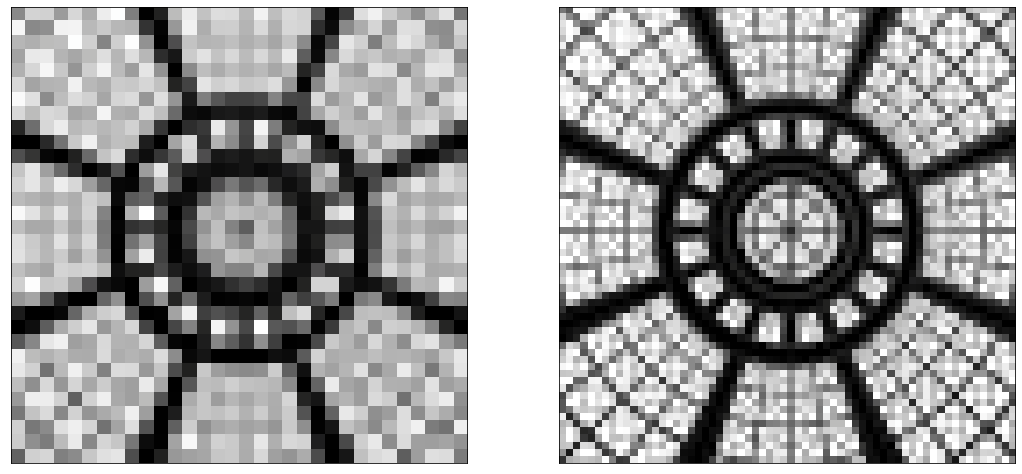

In [37]:
n=465
img=train_ds[n]
predict_image(img[0],img[1],model)
img=train_ds[n]
show_image(img[0],img[1])

In [29]:
torch.save(model.state_dict(), 'low_data_enhancer.pth')